In [1]:
import numpy as np
import qiskit as q
from qiskit import *
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
import pandas as pd
from qiskit.tools.jupyter import *
from scipy.optimize import minimize
from sklearn.preprocessing import Normalizer

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

#import nbimporter
#from Test1 import T1Copy1
#import import_ipynb
#import T1Copy1

backend = BasicAer.get_backend('qasm_simulator')


# Import & Clean

We use as an example the iris dataset. This dataset is composed of 4 variables labelled -1 or 1. We only keep as a feature the 2 first columns and transform the labels as 0 and 1. The data are then padded with constant values and renormalized to have a unitary vector. We use a special routine to encode the data in the quantum circuit. Given a unitary vector of dimension 4, we extract 5 angles with the function get_angles. These angles will serve as arguments to the encoding quantum circuit.

In [2]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1]) ** 2 / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3]) ** 2 / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


data = np.loadtxt("/Users/ezi/Desktop/Disseration/Documentation/iris_classes1and2_scaled.txt")
X = data[:, 0:4]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = (data[:, -1] + 1) / 2

First X sample (original)  : [0.4  0.75 0.2  0.05]
First X sample (padded)    : [0.4  0.75 0.2  0.05 0.3  0.  ]
First X sample (normalized): [0.43259046 0.81110711 0.21629523 0.05407381 0.32444284 0.        ]
First features sample      : [ 0.47588225 -0.24497866  0.24497866 -1.080839    1.080839  ]


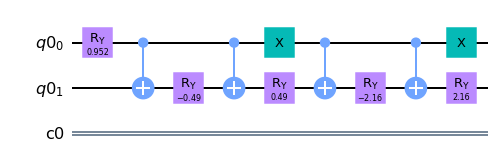

In [3]:
def statepreparation(a, circuit, target):
    
    a = 2*a
    circuit.ry(a[0], target[0])
    
    circuit.cx(target[0], target[1])
    circuit.ry(a[1], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[2], target[1])

    circuit.x(target[0])
    circuit.cx(target[0], target[1])
    circuit.ry(a[3], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[4], target[1])
    circuit.x(target[0])
    
    return circuit

x = X_norm[0]
ang = get_angles(x)
q       = QuantumRegister(2)
c       = ClassicalRegister(1)
circuit = QuantumCircuit(q,c)
circuit = statepreparation(ang, circuit, [0,1])
circuit.draw(output='mpl')

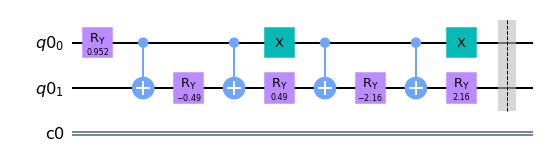

In [4]:
circuit.barrier()

circuit.draw(output='mpl')

# Preparing the circuit

Intermediary functions that will help us to build our circuit.

In [4]:
def u_gate(param, circuit, target):
    '''Return the quantum circuit with u3 gate applied on qubit target with param as an iterable'''
    circuit.u3(param[0],param[1],param[2],target)
    return circuit

def cu_gate(param, circuit, control, target):
    '''Return the quantum circuit with cu3 gate applied on qubit target with param as an iterable wrt control'''
    circuit.cu3(param[0],param[1],param[2], control, target)
    return circuit

def circuit_block(param, circuit, target, same_order_x=True):
    '''Return the block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = u_gate(param[0], circuit, target[0])
    circuit = u_gate(param[1], circuit, target[1])
    if same_order_x:
        circuit.cx(target[0], target[1])
    else:
        circuit.cx(target[1], target[0])
    return circuit

def c_circuit_block(param, circuit, control, target, same_order_x=True):
    '''Return the controlled block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = cu_gate(param[0], circuit, control, target[0])
    circuit = cu_gate(param[1], circuit, control, target[1])
    if same_order_x:
        circuit.ccx(control, target[0], target[1])
    else:
        circuit.ccx(control, target[1], target[0])
    return circuit

def create_circuit(param, circuit, target):
    order = True
    for i in range(param.shape[0]):
        circuit = circuit_block(param[i], circuit, target, order)
        order = not order
    return circuit

def create_c_circuit(param, circuit, control, target):
    order = True
    for i in range(param.shape[0]):
        circuit = c_circuit_block(param[i], circuit, control, target, order)
        order = not order 
    return circuit

/Users/ezi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  This is separate from the ipykernel package so we can avoid doing imports until


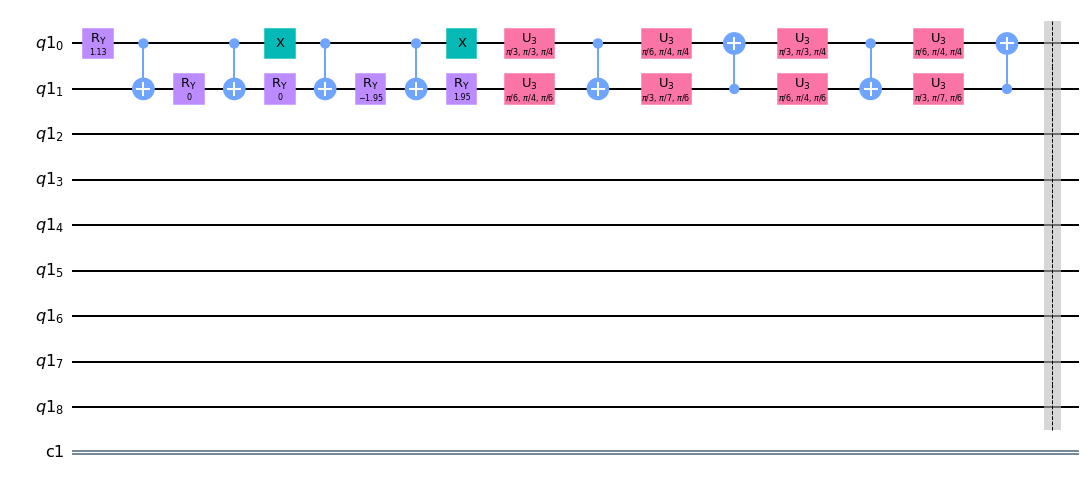

In [5]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)

params = np.array([[[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]],
                    [[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]]])

q       = QuantumRegister(9)
c       = ClassicalRegister(1)
circuit = QuantumCircuit(q,c)
circuit = statepreparation(ang, circuit, [0,1])

circuit = create_circuit(params, circuit, [0,1])

circuit.barrier()

circuit.draw(output='mpl')

# kNN Algorhim 

Encapsulated in a subroutine to save space

In [5]:
n = 9
kNN = QuantumCircuit(n,name='kNN')

kNN.h(0) 
kNN.h(1)

kNN.id(4)
kNN.id(5)
kNN.id(6)
kNN.id(7)
kNN.id(8)

kNN.x(3)#The NOT gate, also known as the Pauli X gate, flips the  state to , and vice versa. 
kNN.cx(1, 3)

kNN.id(4)
kNN.cx(0, 2)
kNN.id(5)
kNN.id(6)
kNN.id(7)
kNN.id(8)

kNN.id(3)
kNN.id(4)
kNN.id(5)
kNN.id(5)
kNN.id(7)
kNN.id(8)



####

kNN.id(0)
kNN.id(1)

kNN.x(2)
kNN.x(3)
kNN.x(4)

kNN.id(5)

kNN.x(6)

kNN.id(7)
kNN.id(8)

#kNN.barrier()


###


kNN.ccx(2, 3, 4)

kNN.id(6)
kNN.id(7)
kNN.id(8)


kNN.ccx(2, 5, 6)

kNN.id(7)
kNN.id(8)


kNN.ccx(2, 6, 5)


kNN.id(7)
kNN.id(8)


kNN.x(6)
          
#circuit.id(qreg_q[2])



kNN.id(5)
kNN.id(7)
kNN.id(8)

#kNN.barrier

######

kNN.ccx(3, 5, 4)



kNN.id(6)
kNN.id(7)
kNN.id(8)



kNN.ccx(3, 5, 6)

kNN.id(7)
kNN.id(8)

kNN.ccx(3, 6, 5)

kNN.id(7)
kNN.id(8)



kNN.x(6)


#circuit.id(qreg_q[3])
#circuit.id(qreg_q[4])


#circuit.id(qreg_q[5])
kNN.id(7)
kNN.id(8)


#####
#kNN.barrier()
kNN.x(4)
kNN.x(5)
kNN.x(6)

kNN.ccx(4, 5,7)
kNN.ccx(6, 7, 8)

kNN.x(8)

kNN.to_gate()

In [6]:
circuit.append(kNN,[0,1,2,3,4,5,6,7,8])
circuit.barrier()
circuit.draw(output="mpl")

CircuitError: 'Index out of range.'

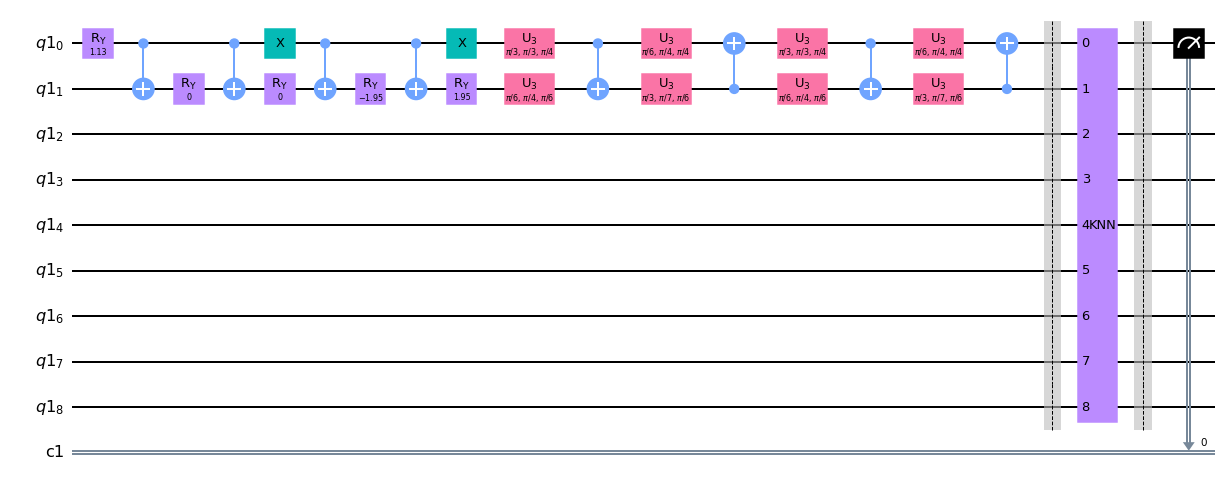

In [8]:
circuit.measure(0,c)
circuit.draw(output="mpl")

# Testing

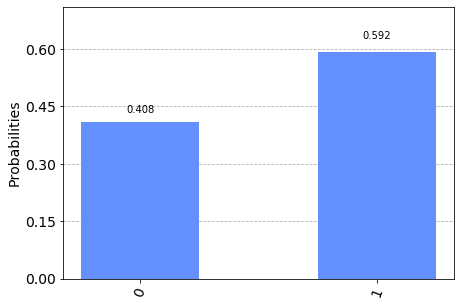

In [9]:
from qiskit.visualization import plot_histogram
emulator = Aer.get_backend('qasm_simulator')

job = execute( circuit, emulator, shots=8192 )

hist = job.result().get_counts()
plot_histogram(hist)

In [10]:
from qiskit import IBMQ
IBMQ.active_account()
IBMQ.save_account('b35ee002c40b58f68333b4dc663e57f118764a66394591bc1270dd258ede51076296505fe28203f55935798b133fda9814350ca6b975b3899b38cbda9a034725', overwrite=True)

IBMQ.load_account()
provider= IBMQ.get_provider(hub='ibm-q')
real_device = provider.get_backend('ibmq_16_melbourne')

/Users/ezi/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [12]:
job = execute(circuit, backend = real_device, shots=8192)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

6013739dd29c1071ca0cfde7
Job Status: job has successfully run


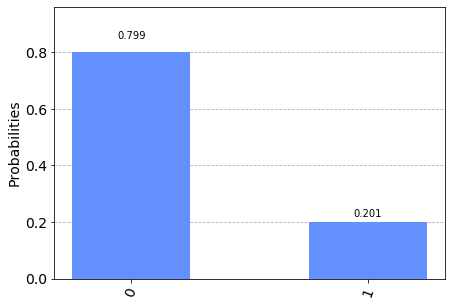

In [13]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

# Hopefully be a scatter plot visualisation 

In [ ]:
from qiskit.tools.jupyter import *

In [14]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

AssertionError: Backend doesn't support Pulse

In [15]:
gnd_results = job.get_memory(0)[:, qubit]*scale_factor
exc_results = job.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

AttributeError: Attribute get_memory is not defined.

In [17]:
def execute_circuit(params, angles=None, x=None, use_angles=True, bias=0, shots=1000):
    if not use_angles:
        angles = get_angles(x)
    q       = QuantumRegister(9)
    c       = ClassicalRegister(9)
    circuit = QuantumCircuit(q,c)
    circuit = statepreparation(angles, circuit, [0,1])

    circuit = create_circuit(params, circuit, [0,1])
    circuit.append(kNN,[0,1,2,3,4,5,6,7,8])
    circuit.measure(0,c)
    result = execute(circuit,backend,shots=shots).result()

    counts = result.get_counts(circuit)
    result=np.zeros(9)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[1] + bias

execute_circuit(params, ang, bias=0.09)

IndexError: index 511 is out of bounds for axis 0 with size 9